# Predictive Modeling: Task Duration Prediction by Task Type

### Using Random Forest Regressor to predict how long each task type will take

In [1]:
# pip install matplotlib scikit-learn seaborn
# !pip install shap

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


In [3]:
# Load the cleaned data
df = pd.read_csv('Technical_Assistance_Cleaned.csv')

print(f"Dataset loaded: {len(df)} rows, {len(df.columns)} columns")
print(f"\nColumns: {df.columns.tolist()}")
df.head()

Dataset loaded: 396 rows, 16 columns

Columns: ['Year', 'Mth', 'Day', 'Engine', 'Variant', 'Brief Description of Technical Intervention', 'Task_1', 'Task_2', 'Task_3', 'Task_4', 'Task_5', 'Task_6', 'task_count', 'task_duration', 'Intervention level', 'By']


,Year,Mth,Day,Engine,Variant,Brief Description of Technical Intervention,Task_1,Task_2,Task_3,Task_4,Task_5,Task_6,task_count,task_duration,Intervention level,By
0,2013,MARCH,14,ARRIEL 2,2S2,MODULE 4 & 5 REPLACEMENT,MO4 REPLACEMENT,MO5 REPLACEMENT,NONE,NaN,NaN,NaN,2,1.0,L2,BS
1,2013,MARCH,27,ARRIEL 1,1S1,"TU347,MO5 REPLACEMENT",TU 347,MO5 REPLACEMENT,NONE,NaN,NaN,NaN,2,1.0,L3,BS
2,2013,APR,9,ACCESSORIES,2D,HMU SLEEVE REPLACEMENT,HMU SLEEVE REPLACEMENT,NaN,NONE,NaN,NaN,NaN,1,1.0,L2,BS
3,2013,MAY,10,ARRIEL 1,1S1,MODULE 1 REPLACEMENT,MO1 REPLACEMENT,NaN,NONE,NaN,NaN,NaN,1,1.0,L2,BS
4,2013,MAY,14,ARRIEL 1,1S1,MODULE 5 REPLACEMENT,MO5 REPLACEMENT,NaN,NONE,NaN,NaN,NaN,1,1.0,L2,KA


### 1. Data Reshaping: Unpivot Tasks
#### Transform from wide format (Task_1, Task_2, Task_3, Task_4, Task_5, Task_6 as columns) to long format (one row per task)

In [4]:
# Reshape data: create one row for each task
task_rows = []

for idx, row in df.iterrows():
    # Common fields for all tasks in this row
    base_data = {
        'Year': row['Year'],
        'Mth': row['Mth'],
        'Engine': row['Engine'],
        'Variant': row['Variant'],
        'Intervention level': row['Intervention level'],
        'By': row['By'],
        'task_count': row['task_count'],
        'task_duration': row['task_duration'],
    }
    
    # Create a row for each non-null task (exclude NONE)
    for task_num in [1, 2, 3, 4, 5, 6]:
        task_col = f'Task_{task_num}'
        if pd.notna(row[task_col]) and str(row[task_col]).strip().upper() != 'NONE':
            task_data = base_data.copy()
            task_data['task_name'] = row[task_col]
            task_data['task_position'] = task_num
            task_rows.append(task_data)

# Create new dataframe with one row per task
df_tasks = pd.DataFrame(task_rows)

print(f"Original dataframe: {len(df)} rows")
print(f"Task-level dataframe: {len(df_tasks)} rows (one row per task, excluding NONE)")
print(f"\nTask-level dataframe columns: {df_tasks.columns.tolist()}")
print(f"\nSample of reshaped data:")
df_tasks.head(10)

Original dataframe: 396 rows
Task-level dataframe: 471 rows (one row per task, excluding NONE)

Task-level dataframe columns: ['Year', 'Mth', 'Engine', 'Variant', 'Intervention level', 'By', 'task_count', 'task_duration', 'task_name', 'task_position']

Sample of reshaped data:


,Year,Mth,Engine,Variant,Intervention level,By,task_count,task_duration,task_name,task_position
0,2013,MARCH,ARRIEL 2,2S2,L2,BS,2,1.0,MO4 REPLACEMENT,1
1,2013,MARCH,ARRIEL 2,2S2,L2,BS,2,1.0,MO5 REPLACEMENT,2
2,2013,MARCH,ARRIEL 1,1S1,L3,BS,2,1.0,TU 347,1
3,2013,MARCH,ARRIEL 1,1S1,L3,BS,2,1.0,MO5 REPLACEMENT,2
4,2013,APR,ACCESSORIES,2D,L2,BS,1,1.0,HMU SLEEVE REPLACEMENT,1
5,2013,MAY,ARRIEL 1,1S1,L2,BS,1,1.0,MO1 REPLACEMENT,1
6,2013,MAY,ARRIEL 1,1S1,L2,KA,1,1.0,MO5 REPLACEMENT,1
7,2013,MAY,ARRIEL 2,2C2,L3,BS,1,1.0,TU 166,1
8,2013,MAY,ARRIEL 2,2C2,L3,BS,1,1.0,TU 166,1
9,2013,MAY,ACCESSORIES,2S2,L2,BS,1,1.0,HMU TBO EXTENTION,1


In [5]:
df_tasks['task_count'].unique()

array([2, 1, 3, 4, 5])

### 2. Exploratory Data Analysis (EDA)

In [6]:
# Check for missing values
print("Missing values in task-level data:")
print(df_tasks.isna().sum())



Missing values in task-level data:
Year                    0
Mth                   112
Engine                  0
Variant                 0
Intervention level      0
By                      0
task_count              0
task_duration           5
task_name               0
task_position           0
dtype: int64


In [7]:
df_tasks = df_tasks.dropna(subset=['task_duration'])
df_tasks.isna().sum()

Year                    0
Mth                   112
Engine                  0
Variant                 0
Intervention level      0
By                      0
task_count              0
task_duration           0
task_name               0
task_position           0
dtype: int64

In [8]:
df_tasks.drop(columns=['Mth', 'Year'], inplace=True)

print("Missing values in task-level data:")
print(df_tasks.isna().sum())

Missing values in task-level data:
Engine                0
Variant               0
Intervention level    0
By                    0
task_count            0
task_duration         0
task_name             0
task_position         0
dtype: int64


In [9]:
# Classify each task into task type categories
task_type_map = {
    # 1. Removal / Installation
    'ADJUSTED VALVE ASSY REMOVAL': 'Removal / Installation',
    'BULKHEAD ASSY REPLACEMENT': 'Removal / Installation',
    'COMPRESSOR COVER REPLACEMENT': 'Removal / Installation',
    'COPPER SEAL CHANGE': 'Removal / Installation',
    'FCU INSTALLATION': 'Removal / Installation',
    'FCU REPLACEMENT': 'Removal / Installation',
    'HELICOIL': 'Removal / Installation',
    'HMU INSTALLATION': 'Removal / Installation',
    'HMU REMOVAL': 'Removal / Installation',
    'HMU SLEEVE REPLACEMENT': 'Removal / Installation',
    'HP PUMP REPLACEMENT': 'Removal / Installation',
    'MAG SEAL REPLACEMENT': 'Removal / Installation',
    'MO1 INSTALLATION': 'Removal / Installation',
    'MO1 REPLACEMENT': 'Removal / Installation',
    'MO2 INSTALLATION': 'Removal / Installation',
    'MO2 REMOVAL': 'Removal / Installation',
    'MO2 REPLACEMENT': 'Removal / Installation',
    'MO3 REPLACEMENT': 'Removal / Installation',
    'MO4 REPLACEMENT': 'Removal / Installation',
    'MO5 REPLACEMENT': 'Removal / Installation',
    'MODULE REPLACEMENT': 'Removal / Installation',
    'NFT SEALOL SEAL REPLACEMENT': 'Removal / Installation',
    'OIL PUMP REMOVAL': 'Removal / Installation',
    'OUTPUT SEAL INSTALLATION': 'Removal / Installation',
    'OUTPUT SEAL REMOVAL': 'Removal / Installation',
    'OVSP DRAIN VALVE': 'Removal / Installation',
    'PT BLADE REPLACEMENT': 'Removal / Installation',
    'PT NGV REPLACEMENT': 'Removal / Installation',
    'REMOVAL FCU': 'Removal / Installation',
    'REMOVE ENGINE FROM CONTAINER': 'Removal / Installation',
    'SELOL SEAL CHANGE': 'Removal / Installation',
    'STANDARD EXCHANGE 02': 'Removal / Installation',
    'STANDARD EXCHANGE 03': 'Removal / Installation',
    'STANDARD EXCHANGE MO1': 'Removal / Installation',
    'STANDARD EXCHANGE MO2': 'Removal / Installation',
    'STANDARD EXCHANGE MO3': 'Removal / Installation',
    'SWAP OF ENGINE BOX BETWEEN 5033 AND 5034': 'Removal / Installation',
    'THREAD INSERT REPLACEMENT': 'Removal / Installation',
    'TRANSFER BOX AND PRESERVATION': 'Removal / Installation',
    'TRANSFER ENGINE STAND': 'Removal / Installation',

    # 2. Inspection / Check
    '150H INSPECTION': 'Inspection / Check',
    '3 HOLLOW STRUT INSPECTION': 'Inspection / Check',
    '500 HRS INSPECTION': 'Inspection / Check',
    '500H INSPECTION': 'Inspection / Check',
    '600H INSPECTION': 'Inspection / Check',
    'ASSESSMENT OF ENGINE': 'Inspection / Check',
    'BLEED VALVE INSPECTION': 'Inspection / Check',
    'BORESCOPE INSPECTION': 'Inspection / Check',
    'ENGINE INSPECTION': 'Inspection / Check',
    'EXTERNAL INSPECTION': 'Inspection / Check',
    'FCU INSPECTION': 'Inspection / Check',
    'HMU VISUAL INSPECTION': 'Inspection / Check',
    'INTERNAL INSPECTION': 'Inspection / Check',
    'LIGHTNING STRIKE INSPECTION': 'Inspection / Check',
    'MO1 INSPECTION': 'Inspection / Check',
    'MO1 OIL DRIP': 'Inspection / Check',
    'MO2 INSPECTION': 'Inspection / Check',
    'MO4 INSPECTION': 'Inspection / Check',
    'MO5 INSPECTION': 'Inspection / Check',
    'PIR': 'Inspection / Check',
    'POST RENTAL INSPECTION': 'Inspection / Check',
    'SCHEDULE INSPECTION': 'Inspection / Check',
    'SCHEDULE INSPECTION 1200FH': 'Inspection / Check',
    'SCHEDULE INSPECTION 600FH': 'Inspection / Check',

    # 3. Tests (Electrical or Functional)
    'TEST OF VISUAL BLOCKAGE INDICATOR': 'Tests',
    'VIBRATION CHECK': 'Tests',
    'FCU CERTIFICATION': 'Tests',

    # 4. Special Procedure
    'BORESCOPE INSPECTION REPORT WITH RELEASE EASA FORM 1': 'Special Procedure',
    'CAAM F1 AMENDMENT': 'Special Procedure',
    'CYCLE COUNTERS UPDATE': 'Special Procedure',
    'EECU RESET': 'Special Procedure',
    'ENGINE PRESERVATION': 'Special Procedure',
    'FINDING ENGINE BEYOND GTA CAPABILITY & WILL BE SEND FOR LEVEL 4 OR OVERHAUL REPAIR': 'Special Procedure',
    'HMU APPL SB 292 73 2836': 'Special Procedure',
    'HMU TBO EXTENTION': 'Special Procedure',
    'KANBAN REPORT': 'Special Procedure',
    'MO2 7 TU 198': 'Special Procedure',
    'MO2 REPAIR': 'Special Procedure',
    'MO3 7 TU198': 'Special Procedure',
    'MO3 CALENDAR RESTORATION': 'Special Procedure',
    'MSB 292 72 2861': 'Special Procedure',
    'OEI COUNTER RESET': 'Special Procedure',
    'RE-CERTIFY UNDER CAAM': 'Special Procedure',
    'SB 298792087': 'Special Procedure',
    'SB 298732097': 'Special Procedure',
    'SB APPLICATION': 'Special Procedure',
    'SB POST TU 347': 'Special Procedure',
    'TECHNICAL REPORT': 'Special Procedure',
    'TF 90': 'Special Procedure',
    'TF 91': 'Special Procedure',
    'TU 166': 'Special Procedure',
    'TU 347': 'Special Procedure',
    'TU 357': 'Special Procedure',
    'TU 360': 'Special Procedure',
    'TU 374': 'Special Procedure',
    'TU 377': 'Special Procedure',
    'TU 81': 'Special Procedure',

    # 5. Cleaning
    'REAR BEARING CLEANING': 'Cleaning',
    
    # 6. Repair
    'REPAIR ESI/MAKILA2A1/757': 'Special Procedure',
}

# Apply mapping
df_tasks['task_type'] = df_tasks['task_name'].map(task_type_map)

# Check for unmapped tasks
unmapped = df_tasks[df_tasks['task_type'].isna()]['task_name'].unique()
if len(unmapped) > 0:
    print(f"WARNING: {len(unmapped)} unmapped tasks: {unmapped}")
else:
    print("All tasks successfully classified!")

# Display distribution
print(f"\nTask Type Distribution:")
print(df_tasks['task_type'].value_counts().to_string())

print(f"\nAverage duration by Task Type:")
for tt in df_tasks['task_type'].unique():
    subset = df_tasks[df_tasks['task_type'] == tt]
    print(f"  {tt}: avg {subset['task_duration'].mean():.1f} days, max {subset['task_duration'].max()} days (n={len(subset)})")

All tasks successfully classified!

Task Type Distribution:
task_type
Inspection / Check        165
Removal / Installation    115
Special Procedure         109
Tests                      72
Cleaning                    5

Average duration by Task Type:
  Removal / Installation: avg 4.0 days, max 100.0 days (n=115)
  Special Procedure: avg 2.3 days, max 25.0 days (n=109)
  Inspection / Check: avg 2.3 days, max 26.0 days (n=165)
  Tests: avg 1.0 days, max 2.0 days (n=72)
  Cleaning: avg 6.4 days, max 23.0 days (n=5)


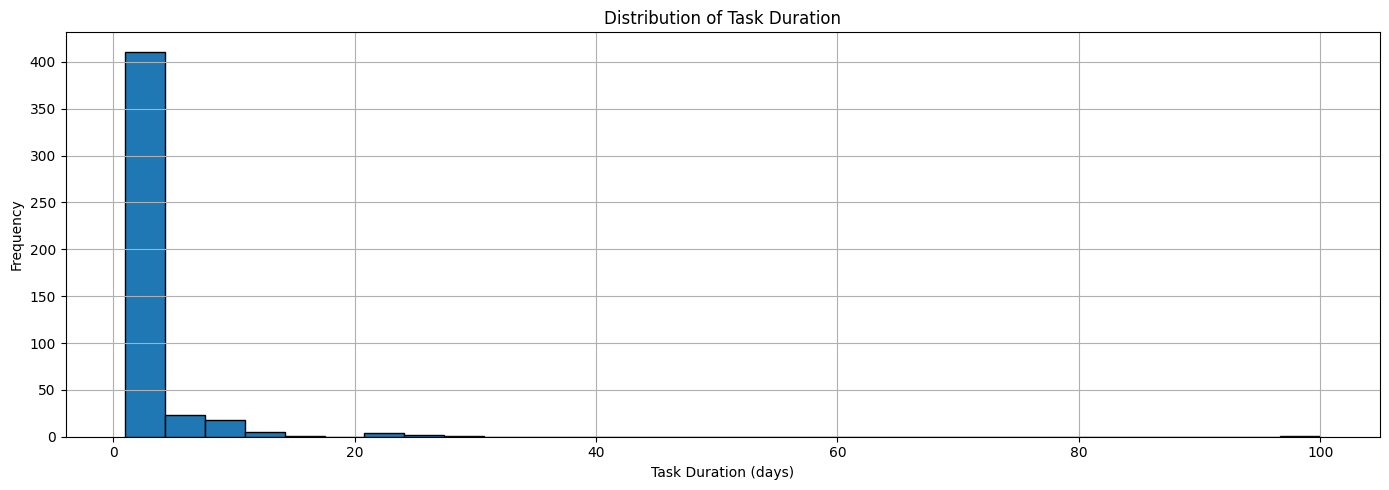


Task Duration Statistics:
count    466.000000
mean       2.564378
std        5.787374
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max      100.000000
Name: task_duration, dtype: float64


In [10]:
# Distribution of task_duration (target variable)
plt.figure(figsize=(14, 5))

df_tasks['task_duration'].hist(bins=30, edgecolor='black')
plt.xlabel('Task Duration (days)')
plt.ylabel('Frequency')
plt.title('Distribution of Task Duration')

plt.tight_layout()
plt.show()

print(f"\nTask Duration Statistics:")
print(df_tasks['task_duration'].describe())

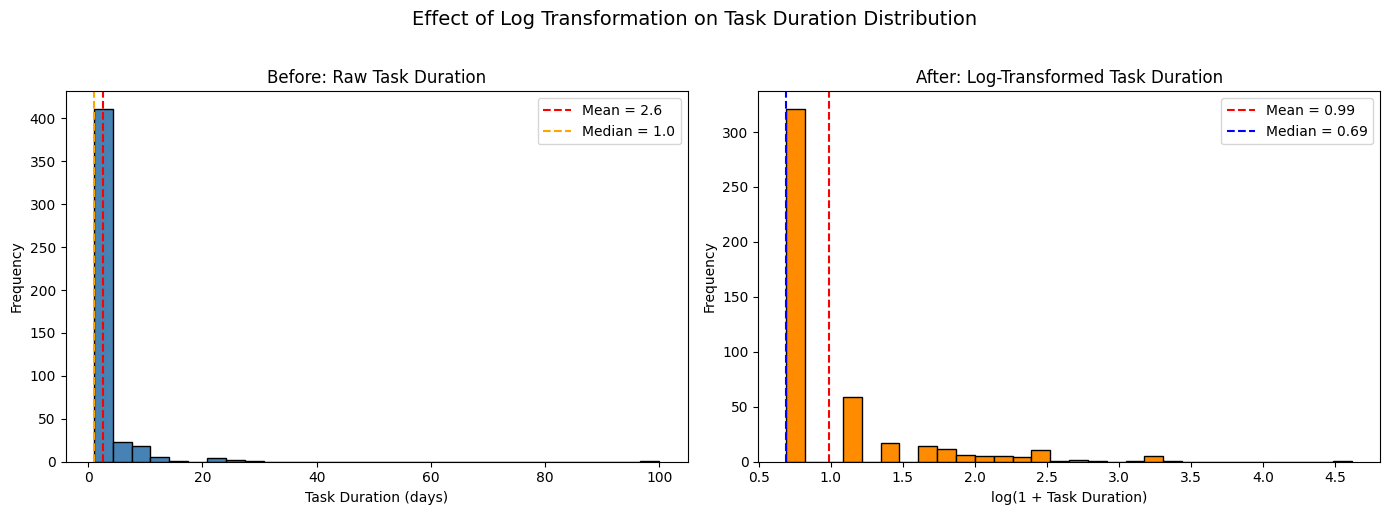

Skewness (raw):             11.307
Skewness (log-transformed): 2.411
Max (log-transformed):      4.62

Log transformation reduced skewness from 11.307 to 2.411


In [11]:
# Distribution of task_duration AFTER log transformation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before: raw duration
axes[0].hist(df_tasks['task_duration'], bins=30, edgecolor='black', color='steelblue')
axes[0].set_xlabel('Task Duration (days)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Before: Raw Task Duration')
axes[0].axvline(df_tasks['task_duration'].mean(), color='red', linestyle='--', label=f"Mean = {df_tasks['task_duration'].mean():.1f}")
axes[0].axvline(df_tasks['task_duration'].median(), color='orange', linestyle='--', label=f"Median = {df_tasks['task_duration'].median():.1f}")
axes[0].legend()

# After: log-transformed duration
log_duration = np.log1p(df_tasks['task_duration'])
axes[1].hist(log_duration, bins=30, edgecolor='black', color='darkorange')
axes[1].set_xlabel('log(1 + Task Duration)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('After: Log-Transformed Task Duration')
axes[1].axvline(log_duration.mean(), color='red', linestyle='--', label=f"Mean = {log_duration.mean():.2f}")
axes[1].axvline(log_duration.median(), color='blue', linestyle='--', label=f"Median = {log_duration.median():.2f}")
axes[1].legend()

plt.suptitle('Effect of Log Transformation on Task Duration Distribution', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Print skewness comparison
from scipy import stats
raw_skew = stats.skew(df_tasks['task_duration'].dropna())
log_skew = stats.skew(log_duration.dropna())
print(f"Skewness (raw):             {raw_skew:.3f}")
print(f"Skewness (log-transformed): {log_skew:.3f}")
print(f"Max (log-transformed):      {log_duration.max():.2f}")
print(f"\nLog transformation reduced skewness from {raw_skew:.3f} to {log_skew:.3f}")

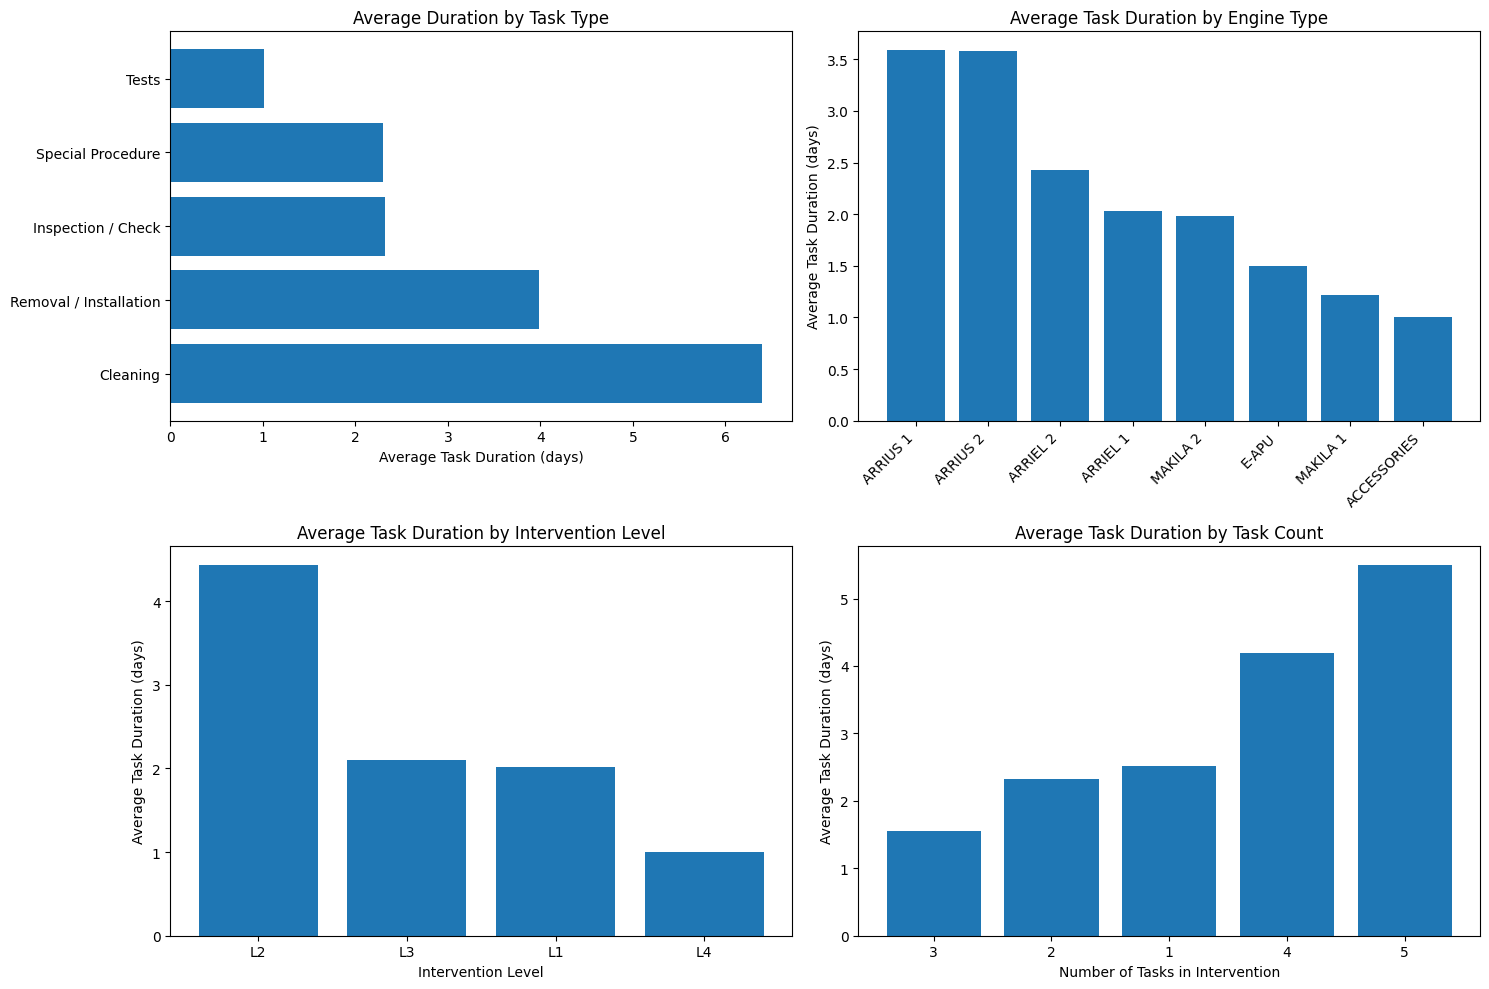

In [12]:
# Analyze task_duration by key features
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Duration by task_type
type_duration = df_tasks.groupby('task_type')['task_duration'].mean().sort_values(ascending=False)
axes[0, 0].barh(type_duration.index, type_duration.values)
axes[0, 0].set_xlabel('Average Task Duration (days)')
axes[0, 0].set_title('Average Duration by Task Type')

# Duration by Engine
engine_duration = df_tasks.groupby('Engine')['task_duration'].mean().sort_values(ascending=False)
axes[0, 1].bar(range(len(engine_duration)), engine_duration.values)
axes[0, 1].set_xticks(range(len(engine_duration)))
axes[0, 1].set_xticklabels(engine_duration.index, rotation=45, ha='right')
axes[0, 1].set_ylabel('Average Task Duration (days)')
axes[0, 1].set_title('Average Task Duration by Engine Type')

# Duration by Intervention Level
level_duration = df_tasks.groupby('Intervention level')['task_duration'].mean().sort_values(ascending=False)
axes[1, 0].bar(level_duration.index, level_duration.values)
axes[1, 0].set_xlabel('Intervention Level')
axes[1, 0].set_ylabel('Average Task Duration (days)')
axes[1, 0].set_title('Average Task Duration by Intervention Level')

# Duration by task_count (number of tasks in the same intervention)
count_duration = df_tasks.groupby('task_count')['task_duration'].mean().sort_values()
axes[1, 1].bar(count_duration.index.astype(str), count_duration.values)
axes[1, 1].set_xlabel('Number of Tasks in Intervention')
axes[1, 1].set_ylabel('Average Task Duration (days)')
axes[1, 1].set_title('Average Task Duration by Task Count')

plt.tight_layout()
plt.show()

### 3. Data Preparation for Modeling

In [13]:
# Create a copy for modeling
df_model = df_tasks.copy()
print(f"Modeling dataframe: {len(df_model)} rows")
print(f"Columns: {df_model.columns.tolist()}")

Modeling dataframe: 466 rows
Columns: ['Engine', 'Variant', 'Intervention level', 'By', 'task_count', 'task_duration', 'task_name', 'task_position', 'task_type']


In [14]:
# Select features for modeling
feature_cols = [
    'task_type',              # Task type category
    'Engine',                 # Engine type
    'Intervention level',     # L1, L2, L3
    'task_count',             # Total number of tasks in this intervention
    'By',
    'Variant'
]

# Keep only columns that exist in the dataframe
feature_cols = [col for col in feature_cols if col in df_model.columns]

print(f"\nFeatures selected for modeling: {feature_cols}")

# Create feature matrix and target (log transform to handle skew)
X = df_model[feature_cols].copy()
y_raw = df_model['task_duration'].copy()
y = np.log1p(y_raw)  # log(1 + duration) to handle skewed distribution

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")
print(f"\nTarget stats (raw): min={y_raw.min()}, max={y_raw.max()}, median={y_raw.median()}")
print(f"Target stats (log): min={y.min():.2f}, max={y.max():.2f}, median={y.median():.2f}")


Features selected for modeling: ['task_type', 'Engine', 'Intervention level', 'task_count', 'By', 'Variant']

Feature matrix shape: (466, 6)
Target variable shape: (466,)

Target stats (raw): min=1.0, max=100.0, median=1.0
Target stats (log): min=0.69, max=4.62, median=0.69


In [15]:
# Encode categorical variables
label_encoders = {}
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

print(f"Encoding {len(categorical_cols)} categorical columns...")

for col in categorical_cols:
    le = LabelEncoder()
    # Handle missing values by filling with a placeholder
    X[col] = X[col].fillna('MISSING')
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le
    print(f"  - {col}: {len(le.classes_)} unique values")

# Fill any remaining missing values in numeric columns
X = X.fillna(0)

print(f"\nFinal feature matrix shape: {X.shape}")
print(f"Features: {X.columns.tolist()}")

Encoding 5 categorical columns...
  - task_type: 5 unique values
  - Engine: 8 unique values
  - Intervention level: 4 unique values
  - By: 15 unique values
  - Variant: 37 unique values

Final feature matrix shape: (466, 6)
Features: ['task_type', 'Engine', 'Intervention level', 'task_count', 'By', 'Variant']


### 4. Train-Test Split

In [16]:
# Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {len(X_train)} samples")
print(f"Testing set: {len(X_test)} samples")
print(f"\nTraining set task_duration stats:")
print(y_train.describe())
print(f"\nTesting set task_duration stats:")
print(y_test.describe())

Training set: 372 samples
Testing set: 94 samples

Training set task_duration stats:
count    372.000000
mean       1.007142
std        0.572693
min        0.693147
25%        0.693147
50%        0.693147
75%        1.098612
max        3.433987
Name: task_duration, dtype: float64

Testing set task_duration stats:
count    94.000000
mean      0.928194
std       0.579013
min       0.693147
25%       0.693147
50%       0.693147
75%       0.693147
max       4.615121
Name: task_duration, dtype: float64


### 5. Model Training

In [17]:
# Train Random Forest Regressor with regularization to reduce overfitting
print("Training Random Forest Regressor for individual task duration prediction...")

rf_model = RandomForestRegressor(
    n_estimators=300,          # More trees for stability
    max_depth=8,               # Limit depth to reduce overfitting
    min_samples_split=10,      # Require more samples to split
    min_samples_leaf=5,        # Require more samples in leaves
    max_features='sqrt',       # Add diversity
    random_state=42,
    n_jobs=-1                  # Use all CPU cores
)

rf_model.fit(X_train, y_train)
print("Model training complete!")

# Cross-validation score
cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='r2')
print(f"\nCross-validated RÂ²: {cv_scores.mean():.3f} +/- {cv_scores.std():.3f}")
print(f"CV scores per fold: {[f'{s:.3f}' for s in cv_scores]}")

Training Random Forest Regressor for individual task duration prediction...
Model training complete!

Cross-validated RÂ²: -2723873932113200929302648979456.000 +/- 5447747864226401858605297958912.000
CV scores per fold: ['-13619369660566005772413151739904.000', '0.228', '-0.044', '-0.054', '-0.021']


### 6. Model Evaluation

In [18]:
# Make predictions (in log space)
y_train_pred_log = rf_model.predict(X_train)
y_test_pred_log = rf_model.predict(X_test)

# Convert back to original scale for interpretable metrics
y_train_pred = np.expm1(y_train_pred_log)
y_test_pred = np.expm1(y_test_pred_log)
y_train_actual = np.expm1(y_train)
y_test_actual = np.expm1(y_test)

# Calculate metrics on original scale
train_mae = mean_absolute_error(y_train_actual, y_train_pred)
test_mae = mean_absolute_error(y_test_actual, y_test_pred)

train_rmse = np.sqrt(mean_squared_error(y_train_actual, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test_actual, y_test_pred))

# RÂ² on log scale (what the model actually optimizes)
train_r2_log = r2_score(y_train, y_train_pred_log)
test_r2_log = r2_score(y_test, y_test_pred_log)

# RÂ² on original scale
train_r2 = r2_score(y_train_actual, y_train_pred)
test_r2 = r2_score(y_test_actual, y_test_pred)

print("=" * 60)
print("MODEL PERFORMANCE - INDIVIDUAL TASK DURATION PREDICTION")
print("=" * 60)
print(f"\nTraining Set:")
print(f"  MAE:  {train_mae:.2f} days")
print(f"  RMSE: {train_rmse:.2f} days")
print(f"  RÂ² Score (log scale): {train_r2_log:.3f}")
print(f"  RÂ² Score (original):  {train_r2:.3f}")

print(f"\nTesting Set:")
print(f"  MAE:  {test_mae:.2f} days")
print(f"  RMSE: {test_rmse:.2f} days")
print(f"  RÂ² Score (log scale): {test_r2_log:.3f}")
print(f"  RÂ² Score (original):  {test_r2:.3f}")

print(f"\nInterpretation:")
print(f"  - On average, task duration predictions are off by {test_mae:.2f} days")
print(f"  - Model explains {test_r2_log*100:.1f}% of variance in log(task duration)")

MODEL PERFORMANCE - INDIVIDUAL TASK DURATION PREDICTION

Training Set:
  MAE:  1.37 days
  RMSE: 3.50 days
  RÂ² Score (log scale): 0.395
  RÂ² Score (original):  0.184

Testing Set:
  MAE:  1.99 days
  RMSE: 10.15 days
  RÂ² Score (log scale): 0.261
  RÂ² Score (original):  0.030

Interpretation:
  - On average, task duration predictions are off by 1.99 days
  - Model explains 26.1% of variance in log(task duration)


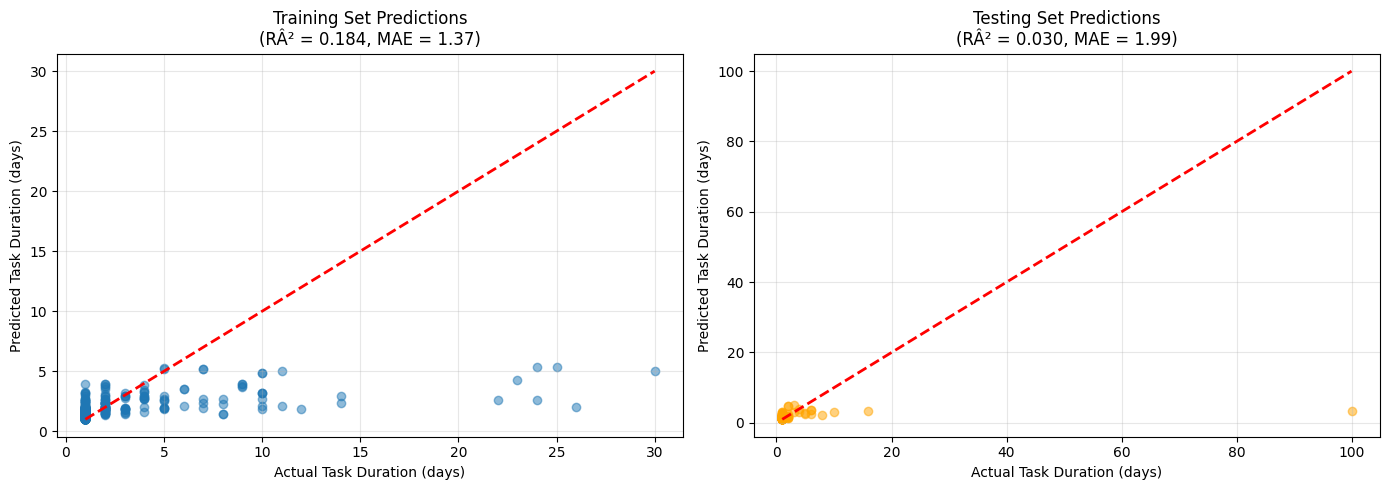

In [19]:
# Visualize predictions vs actual (original scale)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training set
axes[0].scatter(y_train_actual, y_train_pred, alpha=0.5)
axes[0].plot([y_train_actual.min(), y_train_actual.max()], [y_train_actual.min(), y_train_actual.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Task Duration (days)')
axes[0].set_ylabel('Predicted Task Duration (days)')
axes[0].set_title(f'Training Set Predictions\n(RÂ² = {train_r2:.3f}, MAE = {train_mae:.2f})')
axes[0].grid(True, alpha=0.3)

# Testing set
axes[1].scatter(y_test_actual, y_test_pred, alpha=0.5, color='orange')
axes[1].plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Task Duration (days)')
axes[1].set_ylabel('Predicted Task Duration (days)')
axes[1].set_title(f'Testing Set Predictions\n(RÂ² = {test_r2:.3f}, MAE = {test_mae:.2f})')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 7. Feature Importance Analysis

Feature Importance (All Features):
              feature  importance
5             Variant    0.315372
4                  By    0.193767
2  Intervention level    0.143443
3          task_count    0.142243
1              Engine    0.104159
0           task_type    0.101017


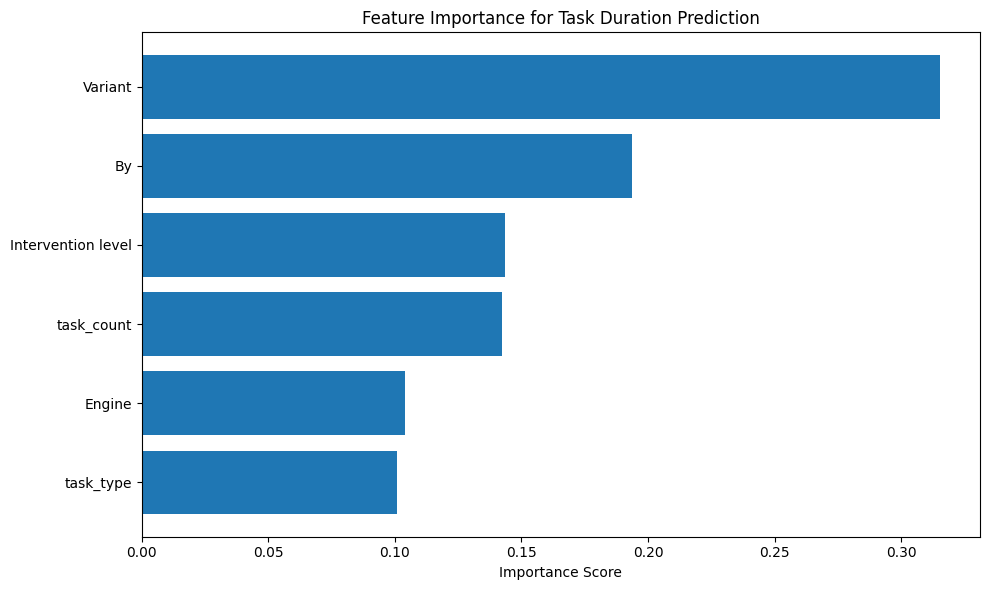

In [20]:
# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Feature Importance (All Features):")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance Score')
plt.title('Feature Importance for Task Duration Prediction')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### 8. SHAP Analysis

#### SHAP (SHapley Additive exPlanations) shows how each feature contributes to individual duration predictions, which is more interpretable than default feature importance.

c:\Users\alyah\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\alyah\AppData\Local\Temp\ipykernel_5496\3799486926.py:14: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, feature_names=X.columns.tolist())


SHAP values shape: (94, 6)
Features: ['task_type', 'Engine', 'Intervention level', 'task_count', 'By', 'Variant']

SHAP Summary Plot: Impact of each feature on predicted task duration (log scale)


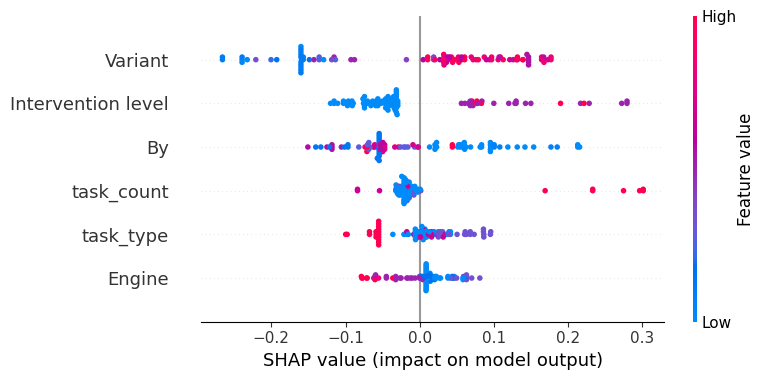

In [21]:
import shap

# Create SHAP explainer for the Random Forest Regressor
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer(X_test)

print(f"SHAP values shape: {shap_values.shape}")
print(f"Features: {X.columns.tolist()}")

# SHAP Summary Plot (Beeswarm)
# Each dot = one test sample; color = feature value (red=high, blue=low)
# X-axis = SHAP value (positive = pushes predicted duration higher)
print("\nSHAP Summary Plot: Impact of each feature on predicted task duration (log scale)")
shap.summary_plot(shap_values, X_test, feature_names=X.columns.tolist())

SHAP Bar Plot: Mean feature importance for task duration prediction


C:\Users\alyah\AppData\Local\Temp\ipykernel_5496\3632238990.py:3: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, feature_names=X.columns.tolist(), plot_type="bar")


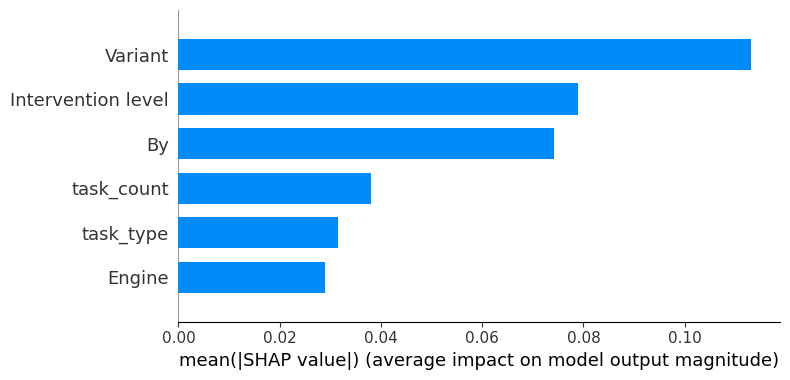

In [22]:
# SHAP Bar Plot: Mean absolute SHAP values (simpler global importance view)
print("SHAP Bar Plot: Mean feature importance for task duration prediction")
shap.summary_plot(shap_values, X_test, feature_names=X.columns.tolist(), plot_type="bar")

### 9. Predictions by Task Type

Task Type Duration Predictions (Test Set):
                        actual_mean  actual_median  count  predicted_mean  \
task_type                                                                   
Removal / Installation         7.59            1.5     22            2.62   
Cleaning                       3.00            3.0      2            2.50   
Inspection / Check             1.58            1.0     36            1.91   
Special Procedure              1.06            1.0     17            1.55   
Tests                          1.06            1.0     17            1.05   

                        predicted_median  error  
task_type                                        
Removal / Installation              2.69   4.97  
Cleaning                            2.50   0.50  
Inspection / Check                  1.82   0.33  
Special Procedure                   1.46   0.49  
Tests                               1.00   0.01  


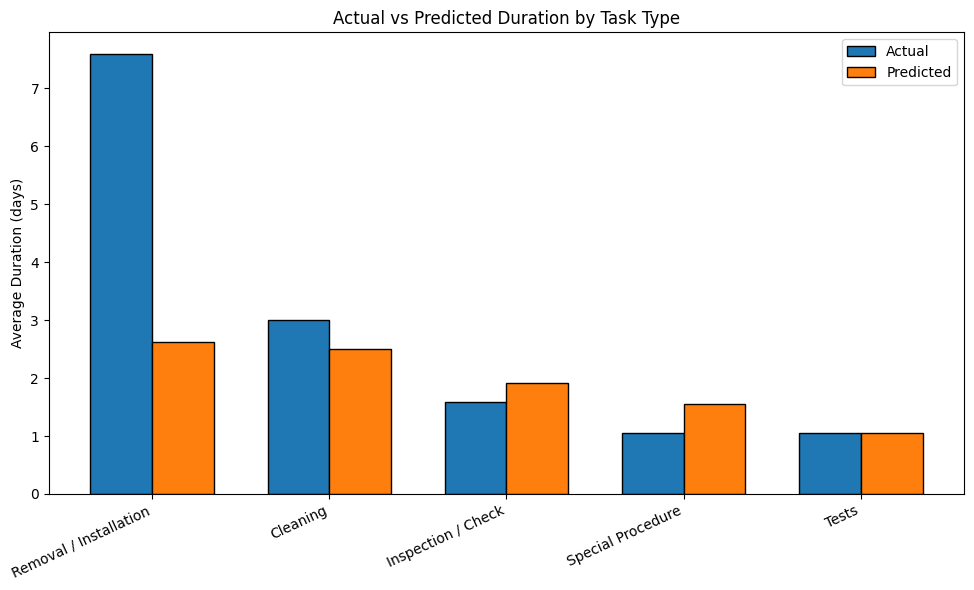

In [23]:
# Get predictions for each unique task type in the test set
import math

test_results = pd.DataFrame({
    'task_type_encoded': X_test['task_type'],
    'actual_duration': y_test_actual,
    'predicted_duration': y_test_pred
})

# Decode task type names
if 'task_type' in label_encoders:
    test_results['task_type'] = label_encoders['task_type'].inverse_transform(test_results['task_type_encoded'])
    
    # Group by task type and show average actual vs predicted duration
    type_comparison = test_results.groupby('task_type').agg({
        'actual_duration': ['mean', 'median', 'count'],
        'predicted_duration': ['mean', 'median']
    }).round(2)
    type_comparison.columns = ['actual_mean', 'actual_median', 'count', 'predicted_mean', 'predicted_median']
    
    # Round up predicted values to whole numbers
    type_comparison['predicted_mean'] = type_comparison['predicted_mean']
    type_comparison['predicted_median'] = type_comparison['predicted_median']
    
    type_comparison['error'] = (type_comparison['predicted_mean'] - type_comparison['actual_mean']).abs().round(2)
    type_comparison = type_comparison.sort_values('actual_mean', ascending=False)
    
    print("Task Type Duration Predictions (Test Set):")
    print(type_comparison)
    
    # Visualize actual vs predicted by task type
    fig, ax = plt.subplots(figsize=(10, 6))
    x = range(len(type_comparison))
    width = 0.35
    ax.bar([i - width/2 for i in x], type_comparison['actual_mean'], width, label='Actual', edgecolor='black')
    ax.bar([i + width/2 for i in x], type_comparison['predicted_mean'], width, label='Predicted', edgecolor='black')
    ax.set_xticks(x)
    ax.set_xticklabels(type_comparison.index, rotation=25, ha='right')
    ax.set_ylabel('Average Duration (days)')
    ax.set_title('Actual vs Predicted Duration by Task Type')
    ax.legend()
    plt.tight_layout()
    plt.show()

In [24]:
type_comparison.to_csv('task_type_predictions.csv')
print("Saved to task_type_predictions.csv")
print(type_comparison)

Saved to task_type_predictions.csv
                        actual_mean  actual_median  count  predicted_mean  \
task_type                                                                   
Removal / Installation         7.59            1.5     22            2.62   
Cleaning                       3.00            3.0      2            2.50   
Inspection / Check             1.58            1.0     36            1.91   
Special Procedure              1.06            1.0     17            1.55   
Tests                          1.06            1.0     17            1.05   

                        predicted_median  error  
task_type                                        
Removal / Installation              2.69   4.97  
Cleaning                            2.50   0.50  
Inspection / Check                  1.82   0.33  
Special Procedure                   1.46   0.49  
Tests                               1.00   0.01  
